# Assignment 3  
## Applied Machine Learning

Andrew Chan 
EBE869

This assignment uses the `Suicide Rates Overview 1985 to 2016` dataset from Kaggle: https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016. This assumes that you have downloaded the dataset in `master.csv` which is in the same directory as this notebook.

In [1]:
import pandas as pd
import math
import numpy as np

# Locate and load the data file
df = pd.read_csv('master.csv')

# Sanity check
print(f'N rows={len(df)}, M columns={len(df.columns)}')
df.head()

N rows=27820, M columns=12


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [2]:
df.columns.values

array(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype=object)

Adjust the gdp_for_year ($) from string to float.

In [3]:
df[' gdp_for_year ($) ']

0         2,156,624,900
1         2,156,624,900
2         2,156,624,900
3         2,156,624,900
4         2,156,624,900
              ...      
27815    63,067,077,179
27816    63,067,077,179
27817    63,067,077,179
27818    63,067,077,179
27819    63,067,077,179
Name:  gdp_for_year ($) , Length: 27820, dtype: object

In [4]:
df[' gdp_for_year ($) '] = df[' gdp_for_year ($) '].str.replace(',', '')

In [5]:
df[' gdp_for_year ($) '] = df[' gdp_for_year ($) '].astype(float) 

In [6]:
df[' gdp_for_year ($) '] 

0        2.156625e+09
1        2.156625e+09
2        2.156625e+09
3        2.156625e+09
4        2.156625e+09
             ...     
27815    6.306708e+10
27816    6.306708e+10
27817    6.306708e+10
27818    6.306708e+10
27819    6.306708e+10
Name:  gdp_for_year ($) , Length: 27820, dtype: float64

# 1. [20 pts] Due to the severity of this real-world crisis, what information would be the most important one to "machine learn"? Can it be learned?

The most important target variable to machine learn is `suicides/100k pop` as we would like to be able to predict low versus high suicide rates. We would also like to determine what factors may lead to higher suicide rates. Predicting this variable will allow countries to issue multilateral policies to help reduce future deaths. For example, it if it found that `age` is a large factor in suicide rates, countries can focus on preventative social wellness programs for those specific groups. 

# 2. [20 pts] Explain in detail how one should set up the problem? Would it be a regression or a classification problem? Any unsupervised approach to see some patterns exist or not?

To attempt a machine learning solution we will turn this into a binary classification problem of `low suicide rate` versus `high suicide rate`. Framing the problem this way will allow us to train a classifier. 

The steps to take will be the following:
1. We will use the dependent variable `suicides/100k pop`
2. Then calculate the mean of this feature `suicides_mean`
3. Convert the data into a binary classification problem such that   
    a. If the value is > than `suicides_mean` then convert to **`high suicide rate`**  
    b. If the value is < than `suicides_mean` then convert to **`low suicide rate`**   

We can use clustering to see which variables may have most effect by creating a pairplot of the features compared to the target variable. See Question 5 `part 1b` for the unsupervised pair plots.

# 3. [20 pts] What should be the dependent variable?

The dependent variable will be generated from the `suicides/100k pop`. We have chosen to use this versus `suicides_no` because this is normalized to population versus an absolute number of suicides. This will help provide a better prediction so that the model does not skew towards larger countries which may naturally have more suicides. 

# 4. [20 pts] Rank the variables to find some strong correlations between the independent variables and the dependent variable you decided

Use the correlation function from pandas:

In [7]:
df_correlation = df.corr()

Sort by the dependent variable:

In [8]:
df_correlation.sort_values(by='suicides/100k pop',ascending=False)

,year,suicides_no,population,suicides/100k pop,HDI for year,gdp_for_year ($),gdp_per_capita ($)
suicides/100k pop,-0.039037,0.306604,0.008285,1.000000,0.074279,0.025240,0.001785
suicides_no,-0.004546,1.000000,0.616162,0.306604,0.151399,0.430096,0.061330
HDI for year,0.366786,0.151399,0.102943,0.074279,1.000000,0.305193,0.771228
gdp_for_year ($),0.094529,0.430096,0.710697,0.025240,0.305193,1.000000,0.303405
population,0.008850,0.616162,1.000000,0.008285,0.102943,0.710697,0.081510
gdp_per_capita ($),0.339134,0.061330,0.081510,0.001785,0.771228,0.303405,1.000000
year,1.000000,-0.004546,0.008850,-0.039037,0.366786,0.094529,0.339134


It seems that the strong correlations exist for:
* suicides_no
* HDI for year
* gdp_for_year ($)

# 5. [20 pts] Pre-process the dataset and list the major features you want to use. 
Note that not all features are crucial. For example, country-year variable is a derived feature and for a classifier it would not be necessary to include the year, the country and the country-year together. In fact, one must avoid adding a derived feature and the original at the same time.

List the independent features you want to use.

## Preprocessing Steps:

### 1a. Convert dependent variable to binary values

In [9]:
suicides_mean = df["suicides/100k pop"].mean()
suicides_mean

12.816097411933894

We will create a modify `suicides/100k pop` as follows:  
* All values larger than or equal to `suicides_mean` will be labelled with `high suicide rate` 
* All values smaller than `suicides_mean` will be labelled with `low suicide rate` 

In [10]:
def isHigh(x, mean_val):
    if x > mean_val:
        return 'high suicide rate'
    else:
        return 'low suicide rate'
df['suicides/100k pop'] = df['suicides/100k pop'].apply(isHigh, args=[suicides_mean])
df['suicides/100k pop'].value_counts()

low suicide rate     19061
high suicide rate     8759
Name: suicides/100k pop, dtype: int64

In [11]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,low suicide rate,Albania1987,NaN,2.156625e+09,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,low suicide rate,Albania1987,NaN,2.156625e+09,796,Silent
2,Albania,1987,female,15-24 years,14,289700,low suicide rate,Albania1987,NaN,2.156625e+09,796,Generation X
3,Albania,1987,male,75+ years,1,21800,low suicide rate,Albania1987,NaN,2.156625e+09,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,low suicide rate,Albania1987,NaN,2.156625e+09,796,Boomers


### 1b. Pair Plotting

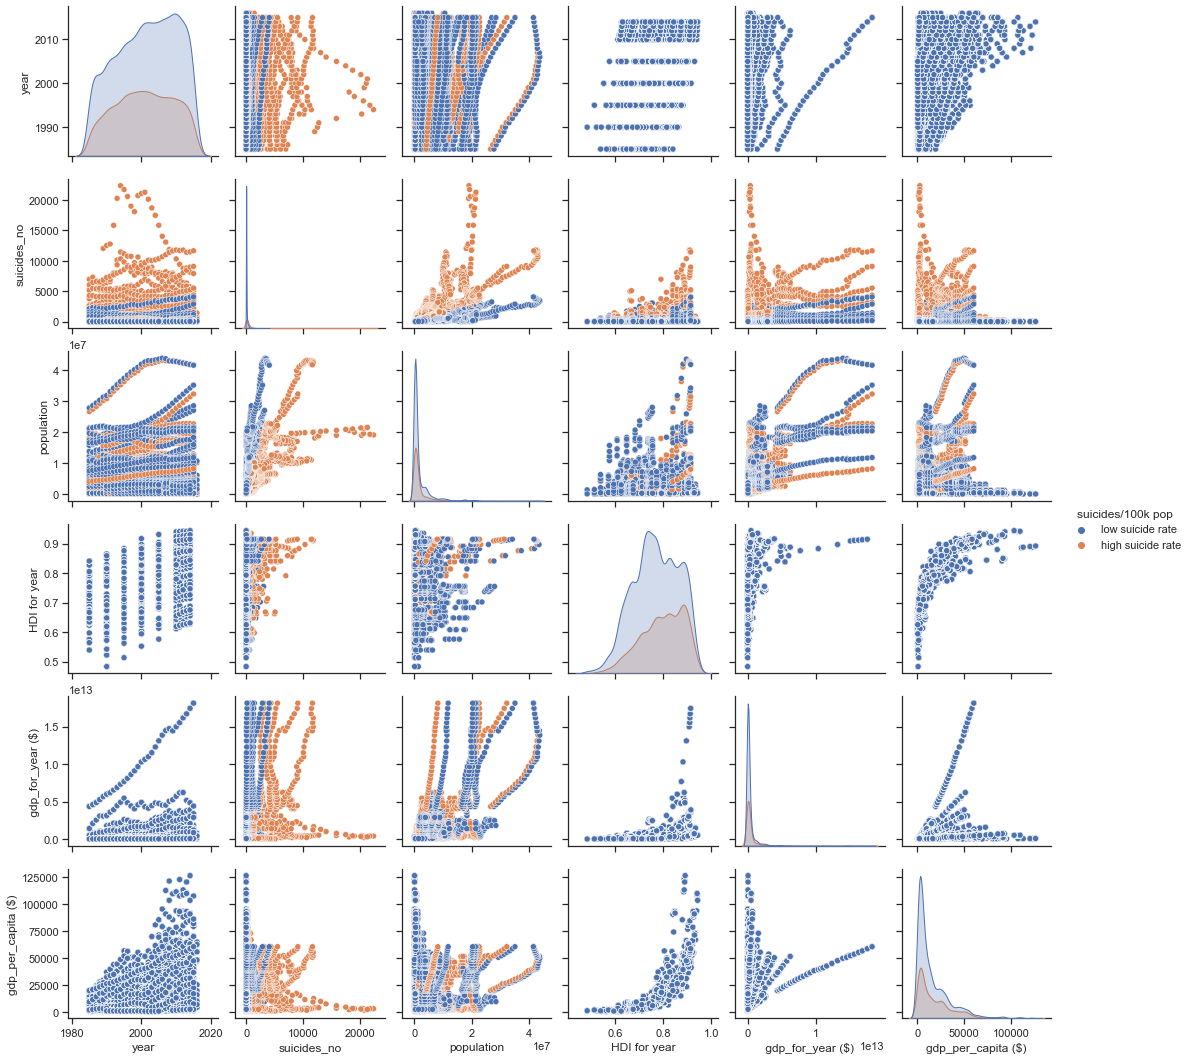

In [12]:
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
cols = df.columns.drop(['suicides/100k pop','country','country-year','sex','age','generation'])
df[cols] = df[cols].apply(pd.to_numeric)
g = sns.pairplot(df, hue='suicides/100k pop')

### 2. Removal redundant features

#### 2a. Remove `suicides_no`

`suicides_no` is highly correlated with with `suicides/100k pop`. Since `suicides/100k pop` was chosen as the dependent variable, it does not make sense to use `suicides_no` since `suicides/100k pop` is $$\frac{suicides\_no}{population/100000}$$ which is a derived attribute. 

Another reason why I chose to keep `suicides/100k pop` is because it helps **normalize suicides by population**. A large country may have many suicides because there are more people that live there, but a smaller country may have more suicides per population. 

In [13]:
df = df.drop(['suicides_no'], axis=1)

#### 2b. Remove `gdp_for_year ($)`

`gdp_for_year ($)` is highly correlated with with `gdp_per_capita ($)`. Since `gdp_per_capita ($)` was chosen as the dependent variable, it does not make sense to use `gdp_for_year ($)` since `gdp_per_capita ($)` is $$\frac{gdp\_for\_year ($)}{population}$$ which is a derived attribute.


Another reason why I chose to keep `gdp_per_capita ($)` is because it helps **normalize GDP by population**. A large country may have more gross domestic product because there are more people that live there, but a smaller country may have more gdp per capita. 

In [14]:
df = df.drop([' gdp_for_year ($) '], axis=1)

#### 2c. Remove `country-year`

Since `country-year` already is derived from `country` and `year`, it is redundant to include the `country-year`. Thus, we drop `country-year`.

I also chose to keep `country` and `year` because upon one-hot encoding, there will be **N countries** + **M years** columns versus **N x M** additional columns, which should help with computational speed. 

In [15]:
df = df.drop(['country-year'], axis=1)

### 3. Mean imputation

For all values with NaN, we will replace with mean so that we do not lose information.

In [16]:
df = df.fillna(df.mean())

In [17]:
final_features = df.columns

In [18]:
df.head()

,country,year,sex,age,population,suicides/100k pop,HDI for year,gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,312900,low suicide rate,0.776601,796,Generation X
1,Albania,1987,male,35-54 years,308000,low suicide rate,0.776601,796,Silent
2,Albania,1987,female,15-24 years,289700,low suicide rate,0.776601,796,Generation X
3,Albania,1987,male,75+ years,21800,low suicide rate,0.776601,796,G.I. Generation
4,Albania,1987,male,25-34 years,274300,low suicide rate,0.776601,796,Boomers


### 4. One hot encoding of all nominal features

In [19]:
df_no_target = pd.get_dummies(df[['country','year','sex','age','population','HDI for year','gdp_per_capita ($)','generation']], drop_first = True)
df_no_target.head()

,year,population,HDI for year,gdp_per_capita ($),country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,country_Australia,country_Austria,...,age_25-34 years,age_35-54 years,age_5-14 years,age_55-74 years,age_75+ years,generation_G.I. Generation,generation_Generation X,generation_Generation Z,generation_Millenials,generation_Silent
0,1987,312900,0.776601,796,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1987,308000,0.776601,796,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1987,289700,0.776601,796,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1987,21800,0.776601,796,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,1987,274300,0.776601,796,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### 6. Normalization and Standardization

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_no_target[['year', 'population', 'HDI for year', 'gdp_per_capita ($)']] = scaler.fit_transform(df[['year', 'population', 'HDI for year', 'gdp_per_capita ($)']])

## List of features selected

The final list of features is the following:
* 'country'
* 'year'
* 'sex'
* 'age'
* 'population'
* 'suicides/100k pop'
* 'HDI for year' 
* 'gdp_per_capita ($)'
* 'generation'

# 6. [20 pts bonus] Devise a classification problem and present a prototype model.
Note that we will continue to this problem in the following modules.

We will create a model using svc and a train test split of 0.75 and 0.25.

Set the x and y values:

In [21]:
df_y = df['suicides/100k pop']
df_X = df_no_target
y = df_y.values
X = df_X.values

In [22]:
from sklearn.model_selection import train_test_split

Use the default train test split of 0.75 and 0.25.

In [23]:
X_train, X_test, y_train, expected = train_test_split(X, y, random_state=0)

Use linear SVC which is a linear svm that uses one versus rest scheme:

In [24]:
from sklearn.svm import LinearSVC
from sklearn import metrics
clf = LinearSVC(random_state=0,max_iter=4000)
clf.fit(X_train, y_train)

LinearSVC(max_iter=4000, random_state=0)

In [25]:
predicted = clf.predict(X_test)

In [26]:
print(f'Classification report for classifier {clf}:\n{metrics.accuracy_score(expected, predicted)}\n')

Classification report for classifier LinearSVC(max_iter=4000, random_state=0):
0.906254493170381

